### Land cover classification from satellite data with Tensorflow2
Using the Sentinel satellite data to perform land cover/use classfication

Refereence to data curation:

[1] Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.

[2] Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

The data can be accessed through the following link: EuroSAT : Land Use and Land Cover Classification with Sentinel-2.

@nasiruddin 

In [ ]:
!pip install np_utils

In [ ]:
# Import libraries 
import os
import zipfile
import matplotlib
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sys
import matplotlib.image as mpimg
from glob import glob 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#Keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.applications.vgg16 import VGG16, preprocess_input
#sklearn helpers
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.manifold import TSNE

In [ ]:
import tensorflow
print(tensorflow.__version__)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [ ]:
#Download the file and save it in a temporary placeholder '/tmp'
!rm -rf eurosat.zip
!rm -rf eurosat/
!wget --no-check-certificate \
  http://madm.dfki.de/files/sentinel/EuroSAT.zip \
  -O /tmp/eurosat.zip

In [ ]:
#Unzip the file in '/tmp'
local_zip = '/tmp/eurosat.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
#Split the data into train, valid, test folders
base_dir = "/tmp/2750"

In [ ]:
Classes = ["AnnualCrop","HerbaceousVegetation","Industrial","PermanentCrop","River","Forest","Highway","Pasture","Residential","SeaLake"]

In [ ]:
NC = len(Classes)
Ncols = 5
Nsamples = []
fig, ax = plt.subplots(nrows = NC, ncols = Ncols, figsize = (5,15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for (i,Class) in enumerate(Classes):
  
  Class_dir = os.path.join(base_dir, Class)
  Class_files = os.listdir(Class_dir)
  nsamples = len(Class_files)
  Nsamples.append(nsamples)
  Class_samples = Class_files[:Ncols]
  
  for j in range(Ncols):
    
    img_path = os.path.join(Class_dir, Class_samples[j])
    img = mpimg.imread(img_path)
    ax[i, j].imshow(img)
    ax[i,0].set_ylabel(Class, fontsize = 10)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

plt.tight_layout()  

In [ ]:
plt.figure(figsize = (20,5))
plt.bar(Classes, Nsamples, width = 0.5, color = "violet", label='Alone')
plt.ylabel("Number of instances in each class", fontsize  = 10)

### VGG16 Transfer learning 

In [ ]:
## Variables
LR = 0.001
BATCH_SIZE = 64
NEPOCHS = 15
IMG_WIDTH, IMG_HEIGHT = 75, 75
VALIDATION_RATIO = 0.2

In [ ]:
## image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip=True,
    
    validation_split=VALIDATION_RATIO) # set validation split

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') 

validation_generator = datagen.flow_from_directory(
    base_dir, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') 

In [ ]:
# Define training model
def vgg_model(retrain = False):
    """
    DENSNET model + 1 deep layer 
    """
    baseModel = VGG16(weights="imagenet", include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))
    #If retrain is set to False, freeze the VGG16 layers:
    if retrain == False:
        for layer in baseModel.layers:
	          layer.trainable = False
    x = baseModel.output
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(10, activation="softmax")(x)

    # Configure the model
    model = Model(baseModel.input, x)
    
    return model

In [ ]:
model = vgg_model(retrain = True)

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
#Stop the optimization once the validation accuracy converges
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

#Schedul the learning rate
def scheduler(epoch):
  '''
  learning rate scheduler; keeps the learning rate 10^(-3) until 10 and then exponential decrease
  '''
  if epoch < 10:
    return LR
  else:
    return LR * np.exp(0.1 * (10 - epoch))

learning_rate_scheduler = LearningRateScheduler(scheduler)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr = LR), metrics=['acc'])

In [ ]:
history = model.fit_generator(train_generator, epochs=40,validation_data = validation_generator,callbacks=[early_stopping, learning_rate_scheduler])

In [ ]:
def plot_history(history):
  
  plt.figure(figsize = (10,6))
  plt.subplot(1,2,1)
  plt.plot(history.history["loss"], label = "loss", linewidth = 3)
  plt.plot(history.history["val_loss"], label = "validation loss", linewidth = 3)
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history["acc"], label = "accuracy", linewidth = 3)
  plt.plot(history.history["val_acc"], label = "validation accuracy", linewidth = 3)
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.legend()

  return None

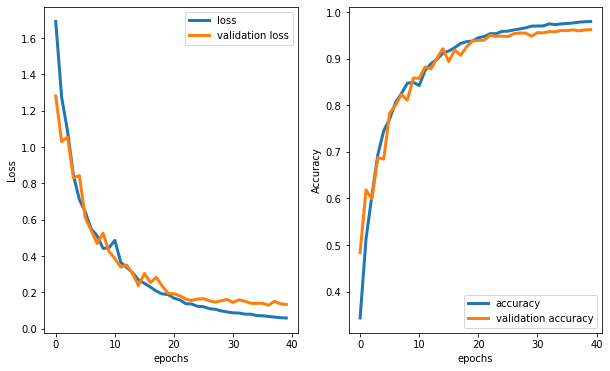

In [23]:
plot_history(history)

In [ ]:
model.save("sentinel2_land_use_vgg.h5")

In [31]:
from google.colab import files
files.download("sentinel2_land_use_vgg.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# save model in google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
!ls /content/gdrive/'My Drive'

'Colab Notebooks'


In [ ]:
# Testing generator
testing_generator = datagen.flow_from_directory(
                        base_dir, 
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        class_mode='categorical',
                        shuffle = False,
                        subset='validation')
test_labels = testing_generator.labels
test_preds = model.predict_generator(testing_generator)
#point-estimates!
test_best = test_preds.argmax(axis = -1)

In [ ]:
report = classification_report(test_labels,
                               test_best,
                               labels = np.arange(10),
                               target_names = Classes)
print(report)

### Looking at activation map

Let's take a look at the activation maps! In particular, let's take the output of top layer before the Softmax layer. For any given image, this output should be 512 dimensional vector.

Then we use the tSNE algorithm to reduce the dimensionality of these outputs.

This help us figure out how well the Network can separate the different classes (SeaLakes, Forests, etc).

In [ ]:
layer_outputs = [layer.output for layer in model.layers][-2]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activation_map = activation_model.predict_generator(testing_generator)

In [ ]:
print("shape of the out put matrix is = " , activation_map.shape)

In [38]:
activation_normalized = preprocessing.normalize(activation_map)

In [39]:
tsne = TSNE(perplexity=200)
activation_proj = tsne.fit_transform(activation_normalized)

(-50.35542240142822, 48.48720874786377, -43.49557304382324, 45.34756278991699)

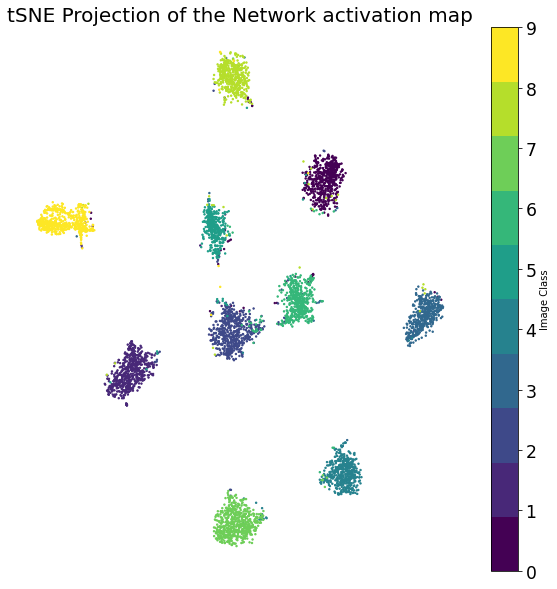

In [40]:
plt.figure(figsize  = (10,10))
plt.scatter(activation_proj[:,0], activation_proj[:,1], c = test_labels, s = 2, cmap=plt.cm.get_cmap('viridis', 10))
cb = plt.colorbar(label='Image Class')
cb.ax.tick_params(labelsize='xx-large')
plt.title("tSNE Projection of the Network activation map", fontsize = 20)
plt.axis('OFF')